## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score

## Loading the dataset

In [2]:
df = pd.read_csv('spam_text_message.csv')

In [3]:
df.head(3)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [4]:
df.shape

(5572, 2)

<b>The dataset has 5572 records and 2 columns</b>

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


<b>Both columns are of object datatype</b>

In [6]:
# Checking if any duplicate records are present

duplicate=df[df.duplicated()] 
duplicate

,Category,Message
103,ham,As per your request 'Melle Melle (Oru Minnamin...
154,ham,As per your request 'Melle Melle (Oru Minnamin...
207,ham,"As I entered my cabin my PA said, '' Happy B'd..."
223,ham,"Sorry, I'll call later"
326,ham,No calls..messages..missed calls
...,...,...
5524,spam,You are awarded a SiPix Digital Camera! call 0...
5535,ham,"I know you are thinkin malaria. But relax, chi..."
5539,ham,Just sleeping..and surfing
5553,ham,Hahaha..use your brain dear


<b>There are 415 duplicate records in the dataset</b>

In [7]:
# Removing duplicate records

df.drop_duplicates(inplace=True)

In [8]:
# Again check if any duplicate records are left

duplicate = df[df.duplicated()] 
duplicate

,Category,Message


<b>Hence, all duplicate records are removed.</b>

In [9]:
df.describe(include='object')

,Category,Message
count,5157,5157
unique,2,5157
top,ham,Wylie update: my weed dealer carlos went to fr...
freq,4516,1


<b> Observations:- </b>

<ul>
    <li>There are 2 unique values in Category column.</li>
    <li>There are 2 unique values in Category column.</li>    

In [10]:
# Checking for null values

df.isnull().sum()

Category    0
Message     0
dtype: int64

<b>The dataset doesn't have any missing values</b>

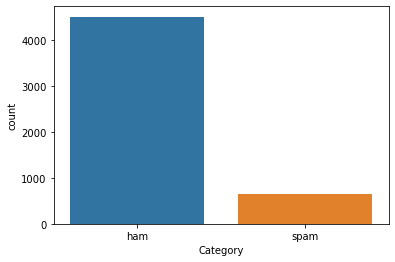

In [11]:
# Visualizing the disribution of ham and spam messages

sns.countplot(df['Category'])

<b> It can be seen that the count of spam messages is much less than ham. </b>

## Text Preprocessing

In [12]:
# Expanding contractions

# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
df['Message'] = df['Message'].apply(lambda x:expand_contractions(x))

In [13]:
# Converting text to lowercase

df['Message'] = df['Message'].apply(lambda x:x.lower())

In [14]:
# Removing digits and words containing digits

df['Message'] = df['Message'].apply(lambda x: re.sub('\w*\d\w*','', x))

In [15]:
# Removing punctuations

df['Message'] = df['Message'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

In [16]:
# Removing extra spaces

df['Message']=df['Message'].apply(lambda x: re.sub(' +',' ',x))

In [17]:
# Displaying the text after cleaning

for index,text in enumerate(df['Message'][0:3]):
    print('Review %d:\n'%(index+1), text)

Review 1:
 go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
Review 2:
 ok lar joking wif u oni
Review 3:
 free entry in a wkly comp to win fa cup final tkts may text fa to to receive entry questionstd txt ratetc is apply is


In [18]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    rev = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text) if w not in stopwords.words('english')]
    rev = ' '.join(rev)
    return rev

df['Message'] = df.Message.apply(lemmatize_text)

In [19]:
# Creating text variable for ham

df_ham = df[df.Category == 'ham']

text_ham = " ".join(text for text in df_ham['Message'])

In [20]:
# Creating text variable for spam

df_spam = df[df.Category == 'spam']

text_spam = " ".join(text for text in df_spam['Message'])

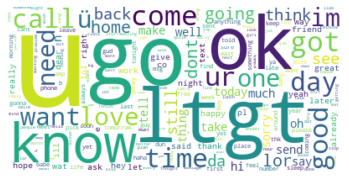

In [21]:
# Creating wordcloud for ham

ham_cloud = WordCloud(collocations = False, background_color = 'white').generate(text_ham)
plt.imshow(ham_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<b> u, go, know, come, good, got, ok, time, ur, need, call etc. are some of the most common words in ham messages. </b> 

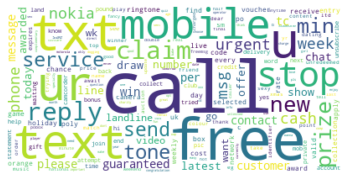

In [22]:
# Creating wordcloud for spam

spam_cloud = WordCloud(collocations = False, background_color = 'white').generate(text_spam)
plt.imshow(spam_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<b> call, free, now, txt, reply, text, claim, prize, mobile, new, service, stop, etc. are some of the most common words in spam messages. </b> 

## Model

In [23]:
# Creating a Bag of Words model

cv = CountVectorizer()
X = cv.fit_transform(df['Message']).toarray()

In [24]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [25]:
# Encoding dependent variable

le = LabelEncoder()
df["Category"] = le.fit_transform(df["Category"])    # ham->0 and spam->1

In [26]:
y = df["Category"]

In [27]:
# Splitting the dataset into train and test 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (4125, 7671)
X_test: (1032, 7671)
y_train: (4125,)
y_test: (1032,)


In [28]:
# Training the model using Naive Bayes classifier

nb = MultinomialNB().fit(X_train, y_train)

In [29]:
print("Score of train data:", nb.score(X_train, y_train))
print("Score of test data:", nb.score(X_test, y_test))

Score of train data: 0.9900606060606061
Score of test data: 0.9612403100775194


<b> The model performs well on train as well as test data </b>

In [30]:
y_pred = nb.predict(X_test)
y_pred

array([0, 1, 0, ..., 0, 0, 0])

In [31]:
# F1 score and accuracy

f1_score = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print("F1 Score:", f1_score)
print("Accuracy Score:", accuracy)

F1 Score: 0.9627414790205487
Accuracy Score: 0.9612403100775194


In [32]:
# Classification Report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       896
           1       0.79      0.96      0.87       136

    accuracy                           0.96      1032
   macro avg       0.89      0.96      0.92      1032
weighted avg       0.97      0.96      0.96      1032



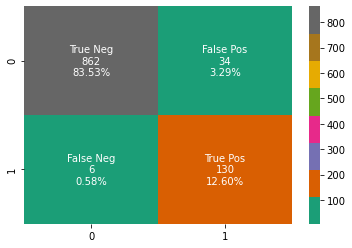

In [33]:
cm = confusion_matrix(y_test, y_pred)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Dark2')